In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

**QUESTÃO 1**

Definimos o código abaixo para obter as matrizes dos sistema linear que deverá ser solucionado para obtermos os coeficientes de cada polinômio

In [2]:
# Função para criar as matrizes do sistema linear obtido 
def spline_cubica(x, fx):
  n = len(x)
  ordem_matriz = 4*n-4
  A = np.zeros((ordem_matriz, ordem_matriz))
  B = np.zeros(ordem_matriz)

  # Condições de continuidade nos nós internos
  for i in range(n-2):
    coluna = 4*i
    linha = 2*i
    A[linha][coluna] = x[i+1]**3
    A[linha][coluna+1] = x[i+1]**2
    A[linha][coluna+2] = x[i+1]
    A[linha][coluna+3] = 1
    B[linha] = fx[i+1]
    A[linha+1][coluna+4] = x[i+1]**3
    A[linha+1][coluna+5] = x[i+1]**2
    A[linha+1][coluna+6] = x[i+1]
    A[linha+1][coluna+7] = 1
    B[linha+1] = fx[i+1]

  # Condições de continuidade nos nós externos
  A[2*n-4][0] = x[0]**3
  A[2*n-4][1] = x[0]**2
  A[2*n-4][2] = x[0]
  A[2*n-4][3] = 1
  B[2*n-4] = fx[0]
  A[2*n-3][ordem_matriz-4] = x[n-1]**3
  A[2*n-3][ordem_matriz-3] = x[n-1]**2
  A[2*n-3][ordem_matriz-2] = x[n-1]
  A[2*n-3][ordem_matriz-1] = 1
  B[2*n-3] = fx[n-1]

  # Continuidade das primeiras derivadas nos nós internos 
  j = 0
  for i in range(2*n-2, 3*n-4):
    A[i][j] = 3*x[(j//4)+1]**2
    A[i][j+1] = 2*x[(j//4)+1]
    A[i][j+2] = 1
    A[i][j+4] = -3*x[(j//4)+1]**2
    A[i][j+5] = -2*x[(j//4)+1]
    A[i][j+6] = -1
    j += 4

  # Continuidade das primeiras derivadas nos nós internos 
  j = 0
  for i in range(3*n-4, 4*n-6):
    A[i][j] = 6*x[(j//4)+1]
    A[i][j+1] = 2
    A[i][j+4] = -6*x[(j//4)+1]
    A[i][j+5] = -2
    j += 4

  # Segundas derivadas nos nós extremos
  A[4*n-6][0] = 6*x[0]
  A[4*n-6][1] = 2
  A[4*n-5][ordem_matriz-4] = 6*x[n-1]
  A[4*n-5][ordem_matriz-3] = 2
  return A, B

Em seguida, definimos o método de Gauss para solucionar tal sistema, bem como uma função para solucionar o sistema equivalente obtido e uma função para realizar o pivoteamento

In [3]:
# Função para solucionar um sistema em que a matriz de coeficientes é triangular superior
def sol_triang_sup(A, B):
  # A é uma matriz triangular inferior e B um vetor com os termos independentes do sistema
  n = len(B)
  X = np.zeros(n)
  for line in range(n-1,-1,-1):
    b = B[line]
    for column in range(n-1,line, -1):
      b -= A[line][column]*X[column]
    x = b/A[line][line]
    # Obtemos os valores de X por substiruições recursivas
    X[line] = x
  return X
  # Retornamos o vetor X

In [4]:
# Função para pivotar duas linhas da matriz
def pivot(A, B, n):
  # A é a martiz de coeficientes do sistema, B um vetor com os termos independentes do sistema e n a coluna à qual será aplicado o pivoteamento
  index_pivo = abs(A[n:,n]).argsort()[-1] + n
  # Encontra a linha do elemento de maior módulo da coluna n buscando a partir da linha n
  aux = np.copy(A[n])
  A[n] = A[index_pivo]
  A[index_pivo] = aux
  # Troca a linha n e a linha com o novo pivô
  aux = B[n]
  B[n] = B[index_pivo]
  B[index_pivo] = aux
  # Aplica a mesma troca ao vetor B
  return A, B # Retorna a matriz A e o vetor B modificados

In [5]:
# Método de eliminação de Gauss
def gauss(A, b, pivotar=False):
  # A é a matriz de coeficientes do sistema, b um vetor com os termos independentes do sistema, pivotar é uma variável que indica se deve ou não se utilizada
  # a estratégia de pivoteamento simples e returnL indica se devem ser retornadas as matrizes L e U para o método LU
  n = len(A)
  A = A.astype(np.float64) 
  b = b.astype(np.float64)
  # Definindo o tipo dos dados como ponto flutuante, para ser possível operar sobre um vetor inteiro de uma só vez
  B = np.copy(b) # Criando uma cópia do vetor B para não alterar o original
  for j in range(n-1): # Itera sobre as colunas de A, exceto a última
    if pivotar:
      A, B = pivot(A, B, j)
    for i in range(j+1,n): # Itera sobre as linhas de A a partir de j+1
      fator = A[i][j]/A[j][j]
      B[i] = B[i] - B[j]*fator # Onde B[i] e B[j] são reais
      A[i] = A[i] - A[j]*fator # Onde A[i] e A[j] são vetores
  return sol_triang_sup(A, B) # Retorna a solução do sistema se returnL = False

Finalmente, definimos uma função para plotar o gráfico das nossas splines

In [6]:
# Função para plotar o gráfico com as splines cúbicas
def plota_spline_cubica(coefic, x):
  n = len(x)
  for i in range(n-1):
    if i == 0:
      X = np.linspace(x[i],x[i+1],100)
      y = coefic[0]*(X**3) + coefic[1]*(X**2) + coefic[2]*X + coefic[3]
    else:
      new_X = np.linspace(x[i],x[i+1],100)
      X = np.concatenate((X, new_X))
      vec = coefic[4*i]*(new_X**3) + coefic[4*i + 1]*(new_X**2) + coefic[4*i + 2]*new_X + coefic[4*i + 3]
      y = np.concatenate((y, vec))
  plt.grid()
  plt.plot(X, y)

Assim, vamos criar as matrizes utilizando os dados do enunciado, onde x = vel (km/h) e f(x) = distância (m)

In [12]:
x1 = np.array([15,20,25,30,40,50])
fx1 = np.array([16,20,34,40,60,90])

In [13]:
A1, B1 = spline_cubica(x1, fx1)
A1

array([[ 8.0000e+03,  4.0000e+02,  2.0000e+01,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.0000e+03,
         4.0000e+02,  2.0000e+01,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.5625e+04,
         6.2500e+02,  2.5000e+01,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  

In [14]:
B1

array([20., 20., 34., 34., 40., 40., 60., 60., 16., 90.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

Em seguida, utilizamos o método da eliminação de Gauss para solucionar o sistema

In [15]:
coefic1 = gauss(A1, B1, True)
coefic1

array([ 2.61656051e-02, -1.17745223e+00,  1.78076433e+01, -7.44968153e+01,
       -5.08280255e-02,  3.44216561e+00, -7.45847134e+01,  5.41452229e+02,
        3.31464968e-02, -2.85592357e+00,  8.28675159e+01, -7.70649682e+02,
       -2.80254777e-03,  3.79490446e-01, -1.41949045e+01,  1.99974522e+02,
       -1.43949045e-03,  2.15923567e-01, -7.65222930e+00,  1.12738854e+02])

E plotamos o gráfico com nossa spline cúbica

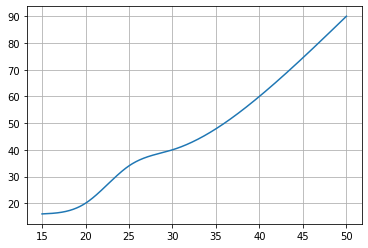

In [17]:
plota_spline_cubica(coefic1, x1)

Por fim, desejamos descobrir f(45), que está dentro do último intervalo analisado ([40,50]). Assim, devemos utilizar os 4 últimos coeficientes e substituir o valor de x no polinômio de terceiro grau obtido por 45

In [18]:
def f1(coefic, x):
  return coefic[-4]*(x**3) + coefic[-3]*(x**2) + coefic[-2]*x + coefic[-1]

In [20]:
f45 = f1(coefic1, 45)
f45

74.46019108280257

Um valor razoável, dado o gráfico obtido anteriormente

**QUESTÃO 2**

Para encontrar o comprimento da pista, devemos integrar a velocidade em relação ao tempo. Para realizar tal procedimento, podemos utilizar qualquer um dos procedimentos já analisados, mas iremos utilizar a função newton_cotes, que utiliza os três métodos mais simples de integração de maneira otimizada

In [21]:
# Método do trapézio simples para calcular a integral de um intervalo [a,b]
def trapezio(a, fa, b, fb):
  return (b-a)*(fa+fb)/2

In [22]:
# Método de 3/8 de Simpson simples
def tresoitavossimpson(pontos):
  # Pontos é uma lista de tuples, onde cada tuple representa o par ordenado (x, f(x))
  return (pontos[3][0]-pontos[0][0])*(pontos[0][1] + 3*pontos[1][1] + 3*pontos[2][1] + pontos[3][1])/8

In [49]:
# Método de 1/3 de Simpson repetida
def simpson_repetida(pontos):
  # Pontos é uma lista de tuples, onde cada tuple representa o par ordenado (x, f(x))
  n = len(pontos)
  resp = 0
  for i in range(n):
    if i == 0 or i == n-1:
      fator = 1
    elif i % 2 == 0:
      fator = 2
    else:
      fator = 4
    resp += fator*pontos[i][1]
  return (pontos[n-1][0]-pontos[0][0])*resp/(3*(n-1))

In [24]:
# Função para calcular de maneira otimizada a integral entre os pontos fornecidos
def newton_cotes(pontos):
  n = len(pontos)
  resp = 0
  i = 0 # i é a variável que representa o menor ponto do intervalo analisado na iteração atual
  while(i<n-1): # De acordo com a definição de i descrita acima, não faz sentido i = n-1, já que pontos[n-1] é o último elemento da lista
    j = i+1 
    count = 1
    # j é uma variável utilizada para contar, juntamente com count, quantos intervalos consecutivos possuem o mesmo tamanho
    # Dessa forma, j representa o menor valor do próximo intervalo e o laço a seguir testa se tal intervalo possui o mesmo tamanho do atual
    while j < n-1 and pontos[j+1][0]-pontos[j][0] == pontos[i+1][0]-pontos[i][0]:
      count += 1
      j += 1
    if count % 2 == 0:
      # Se o número de intervalos consecutivos de mesmo comprimento for par, podemos utilizar o método de 1/3 de Simpson repetido
      resp += simpson_repetida(pontos[i:i+count+1])
    elif count == 3:
      # Se o número de intervalos consecutivos de mesmo comprimento for 3, podemos utilizar o método de 3/8 de Simpson 
      resp += tresoitavossimpson(pontos[i:i+count+1])
    elif count > 3:
      # Se o número de intervalos consecutivos de mesmo comprimento for ímpar e maior que 3, podemos utilizar 
      # O método de 1/3 de Simpson repetido em todos os intervalos menos nos 3 últimos, nos quais vamos utilizar o método de 3/8 de Simpson
      resp += simpson_repetida(pontos[i:i+count-2]) + tresoitavossimpson(pontos[i+count-2:i+count+1])
      # Também é possível utilizar o método de 1/3 de Simpson repetido nos count-1 intervalos e o método do trapézio no último, 
      # porém foi escolhido o método acima, uma vez que o método de 3/8 de Simpson é mais preciso que o do trapézio
    else:
      # Se não houver nenhum intervalo subsequente de mesmo tamanho do atual, devemos aplicar o método do trapézio
      resp += trapezio(pontos[i][0], pontos[i][1], pontos[i+1][0], pontos[i+1][1])
    i += count # A variável i é atualizada para o menor valor do próximo intervalo com tamanho diferente do atual
  return resp

Assim, passamos os dados do enunciado como parâmetros da função, com x = tempo (s) e f(x) = velocidade (m/s)

In [26]:
pontos2 = [(0,62),(0.5,74),(1, 73.5),(1.5,60.5),(48,49.5),(48.5,42.5),(49,39),(59,44.5),(69,58),(79,61.5)]
pontos2

[(0, 62),
 (0.5, 74),
 (1, 73.5),
 (1.5, 60.5),
 (48, 49.5),
 (48.5, 42.5),
 (49, 39),
 (59, 44.5),
 (69, 58),
 (79, 61.5)]

In [27]:
comprimento_pista = newton_cotes(pontos2)
comprimento_pista

4236.520833333334

Portanto, o comprimento da pista é de aproximadamente 4,24 km

**QUESTÃO 3**

Primeiramente, vamos definir o código para solucionar uma integral dupla

In [45]:
# Função para calcular uma integral dupla
def integral_dupla(f, intervalox, nx, intervaloy, ny):
  Y = np.linspace(intervaloy[0], intervaloy[1], ny)
  X = np.linspace(intervalox[0], intervalox[1], nx)
  integrais = [simpson_repetida([(x, f(x, y)) for x in X]) for y in Y ] 
  # Para cada valor de y, calculamos a integral em x
  pontos = [(Y[i], integrais[i]) for i in range(ny)]
  return simpson_repetida(pontos) # Calculamos a integral em y com os valores obtidos anteriormente

Com isso, podemos definir nossa função f(x,y) e solucionar a integral

In [30]:
def f3(x,y):
  return 1/((x+y)**2)

Como hx = 0.2, temos que (4-3)/(nx-1) = 0.2, logo nx = 6. Do mesmo modo, hy = 0.25 significa que (2-1)/(ny-1) = 0.25 e ny = 5, considerando nx e ny o número de pontos de x e y, respectivamente.

In [50]:
I3 = integral_dupla(f3, (3,4), 6, (1,2), 5)
I3

0.03851866147759433

**QUESTÃO 4**

Primeiramente, devemos definir uma função para calcular integrais impróprias. Para isso, podemos observar que, sendo a o limite inferior e b o limite superior, temos que a.b > 0. Logo, podemos utilizar o seguinte artifício

In [62]:
# Método da quadratura gaussiana para 3 pontos
def quadratura_gaussiana(f, a, b):
  # Onde f é a função a ser integrada, a é o limite inferior e b o superior
  t = [-0.7746, 0, 0.7746]
  A = [0.5556, 0.8889, 0.5556]
  # Parâmetros normalizados
  resp = 0
  for i in range(3):
    x = ((b-a)*t[i]+a+b)/2 # Convertendo para o intervalo [a,b]
    resp += A[i]*f(x)
  return (b-a)*resp/2

In [74]:
# Função para calcular uma integral imprópria indo de uma constante positiva à +infinito
def integral_impropria_duplopositivo(g, a):
  return quadratura_gaussiana(g, 0, 1/a) # Para isso, basta realizarmos uma alteração de variável em que 1/x = t
  # e integrarmos de 0 à 1/a

Um detalhe importante é que escollhemos a quadratura gaussiana porque esse método não calcula o valor da função nos extremos (em geral). Tendo em vista que integramos de 0 à um valor positivo e na nossa função a variável aparece no denominador, podemos encontrar um erro caso tentemos integrar utilizando um método que tente obter f(0). Dessa forma, o método da quadratura Gaussiana é o mais adequado.

Assim, devemos apenas definir a função f e a função g que será utilizada para realizar a troca de variável

In [78]:
def f4(x):
  return (x**(-3/2))*np.sin(1/x)

In [79]:
# Função para alterar a variável
def g4(t):
  return f4(1/t)/(t**2)

In [80]:
I4 = integral_impropria_duplopositivo(g4, 2)
I4

0.23242551532460204

Assim, encontramos o valor da nossa integral